In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D

from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import regularizers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.initializers import glorot_normal
from keras.utils import np_utils
from math import ceil,floor
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Training data consists of 9000 numbers in binary representation(n bits) and test contains 1000 samples

In [3]:
n_bits=256

In [13]:
X_train_orig=np.load('xtrain.npy').reshape(-1,n_bits)
y_train_orig=np.load('ytrain.npy').reshape(-1,1)
X_test=np.load('xtest.npy').reshape(-1,n_bits)
y_test=np.load('ytest.npy').reshape(-1,1)

In [5]:
X_train_orig.shape
y_train_orig.shape

(25000, 1)

In [6]:
training_data_size=10000
X_train=X_train_orig[:training_data_size]
y_train=y_train_orig[:training_data_size]

train 9000 epochs 200 acc 0.9990000 inc 2

### Testing out the simplest possible model i.e single layer

In [10]:
model = Sequential()
model.add(Dense(1,activation='relu',input_shape=(n_bits,)))
adam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 257       
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


#### Model has only n_bits+1 parameters, 1 weight for each bit and a bias value

Using early stopping and learning rate decay

In [11]:
early_stop=keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=40, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
reduce_lr=keras.callbacks.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.fit(X_train,y_train,epochs=200,callbacks=[reduce_lr,early_stop])

Epoch 1/200
10000/10000 [==============================] - 0s 38us/step - loss: 3.6123 - accuracy: 0.5106
Epoch 2/200
10000/10000 [==============================] - 0s 31us/step - loss: 2.8850 - accuracy: 0.5410
Epoch 3/200
10000/10000 [==============================] - 0s 25us/step - loss: 2.7895 - accuracy: 0.5866
Epoch 4/200
10000/10000 [==============================] - 0s 36us/step - loss: 2.2800 - accuracy: 0.6056
Epoch 5/200
10000/10000 [==============================] - 0s 28us/step - loss: 4.1179 - accuracy: 0.3695
Epoch 6/200
10000/10000 [==============================] - 0s 48us/step - loss: 1.9224 - accuracy: 0.6157
Epoch 7/200
10000/10000 [==============================] - 1s 103us/step - loss: 1.6750 - accuracy: 0.6564
Epoch 8/200
10000/10000 [==============================] - 0s 37us/step - loss: 1.7317 - accuracy: 0.6291
Epoch 9/200
10000/10000 [==============================] - 0s 37us/step - loss: 1.3234 - accuracy: 0.6754
Epoch 10/200
10000/10000 [===================

10000/10000 [==============================] - 0s 29us/step - loss: 1.0974e-07 - accuracy: 0.9964
Epoch 152/200
10000/10000 [==============================] - 0s 27us/step - loss: 1.0974e-07 - accuracy: 0.9964
Epoch 153/200
10000/10000 [==============================] - 0s 27us/step - loss: 1.0974e-07 - accuracy: 0.9964
Epoch 154/200
10000/10000 [==============================] - 0s 25us/step - loss: 1.0974e-07 - accuracy: 0.9964


In [14]:
model.evaluate(X_test,y_test)[1]

5000/5000 [==============================] - 0s 41us/step


0.996399998664856

Defining a function for Training and evaluating the model for multiple training data sizes

In [16]:
def evalModel(train_size):
    X_train=X_train_orig[:train_size]
    y_train=y_train_orig[:train_size]
    model = Sequential()
    model.add(Dense(1,activation='relu',input_shape=(n_bits,)))
    adam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])
    early_stop=keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=40, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    reduce_lr=keras.callbacks.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    model.fit(X_train,y_train,epochs=200,callbacks=[reduce_lr,early_stop],verbose=0)
    return model.evaluate(X_test,y_test,verbose=0)[1]

In [17]:
train_sizes=[]
accuracies=[]

Training the model for sizes from 100 to 10000 in increments of 200
Corresponding to each dataset size the model is trained and evaluated 5 times and best performance is taken as it was found that model performance was heavily dependent on on initial random initialization and sometimes got stuck in local minima

In [78]:
for i in range(100,10000,200):
    maxacc=0
    for j in range(5):
        maxacc=max(evalModel(i),maxacc)
    train_sizes.append(i)
    accuracies.append(maxacc)
    print(i,maxacc)

100 0.5192000269889832
300 0.48420000076293945
500 0.47760000824928284
700 0.6592000126838684
900 0.5651999711990356
1100 0.8722000122070312
1300 0.8677999973297119
1500 0.8655999898910522
1700 0.9197999835014343
1900 0.9945999979972839
2100 0.8848000168800354
2300 0.9927999973297119
2500 0.9797999858856201
2700 0.9940000176429749
2900 0.9995999932289124
3100 0.9778000116348267
3300 0.9733999967575073
3500 0.9986000061035156
3700 1.0
3900 0.996999979019165
4100 0.9987999796867371
4300 0.9272000193595886
4500 0.9994000196456909
4700 0.9998000264167786
4900 0.9998000264167786
5100 0.991599977016449
5300 0.9976000189781189
5500 0.9941999912261963
5700 1.0
5900 0.9998000264167786


KeyboardInterrupt: 

In [18]:
train_sizes_np=np.array(train_sizes)
accuracies_np=np.array(accuracies)
#np.save('train_sizes',train_sizes_np)
#np.save('accuracies',accuracies_np)

Plot of training data size(x axis) vs accuracy(y axis)

In [19]:
train_sizes=np.load('train_sizes.npy')
accuracies=np.load('accuracies.npy')

Text(0, 0.5, 'Test Accuracy')

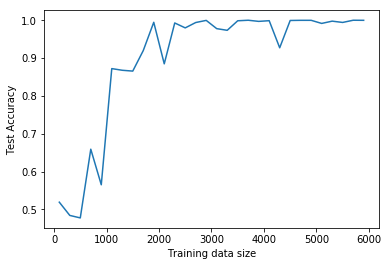

In [24]:
plt.plot(train_sizes,accuracies)
plt.xlabel("Training data size")
plt.ylabel("Test Accuracy")

In [21]:
pred = model.predict(X_test)
for i in range(pred.shape[0]):
    pred[i]=floor(pred[i])


print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2506
           1       1.00      0.99      0.99      2494

   micro avg       0.99      0.99      0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



Finding incorrectly predicted samples

In [22]:

indices = [i for i,v in enumerate(pred) if pred[i]!=y_test[i]]
subset_of_wrongly_predicted = [X_test[i] for i in indices ]
len(subset_of_wrongly_predicted)

28

In [23]:
for i in subset_of_wrongly_predicted:
    
    print(''.join(map(str, i.tolist())))

0111001000100110110100111110111010010000011110000001010000101101010010101101000010101111000111000111010110010100001010100111001010110010101111110101000001110100111111011111000001101001010010100101101001000001000001000011010011011010100100000000110001101100
0010101100010000111010000001100001010011101010101100100101000100001100001011101111100110100000111011111010100011110010111110100001011010000001000100101000100010000101110100010000011001000001111111011010000110101110001010010010000000111001011000011110111000
1001100100100010110010001100111110001000011111001010110100001010111110011001000111011010101110100111011011010100110001000101110101100010101100001010000001100100110111000000100001100111111100110011100000101100000000110001000110001000001100111001110001111010
1111000101111000111000101010111100101000011000101111001001100100011010000011011100101001011100000100010101001000001110000111100010000111000011001110011010110011010100011000001100000111111010001000000101101000110100000011000001011

In [25]:
for layer in model.layers:
    print(layer.get_weights())

[array([[ 9.48245451e-03],
       [ 1.25293005e-02],
       [ 1.09989550e-02],
       [ 9.24004987e-03],
       [ 1.28578460e-02],
       [ 8.85494519e-03],
       [ 1.66592617e-02],
       [-3.66466906e-04],
       [ 1.28666526e-02],
       [ 1.95382945e-02],
       [ 1.37845119e-02],
       [ 2.99780536e-03],
       [ 6.05447544e-03],
       [ 8.68010987e-03],
       [-2.93785986e-03],
       [ 2.84046028e-02],
       [ 5.41815674e-03],
       [ 1.11848405e-02],
       [ 1.13366097e-02],
       [ 1.06764073e-02],
       [ 1.41940173e-03],
       [ 8.30758177e-03],
       [ 6.92257937e-03],
       [ 1.33427335e-02],
       [ 5.12324926e-03],
       [ 6.26291265e-04],
       [ 1.06272073e-02],
       [ 2.52951891e-03],
       [ 1.23886596e-02],
       [ 8.93076044e-03],
       [ 7.01619778e-03],
       [ 1.72126223e-03],
       [ 8.91897269e-03],
       [ 2.09326763e-02],
       [ 1.85775179e-02],
       [ 3.65612209e-02],
       [ 9.64839198e-03],
       [-1.16299568e-02],
       [ 9.

#### Looking at the model weights we can perform adversarial attacks on it due to the way it predicts
For example

In [36]:
test=['0']*256
test=np.array(test).reshape(1,256)
ceil(model.predict(test))
#Output should be 1 as number is even

0

In [38]:
test=['1']*256
test=np.array(test).reshape(1,256)
ceil(model.predict(test))
#Output should be 0 as number is odd

1

### As expected we can see the model has learned to use the last bit in predicting odd/even
**The last neuron has a negtive weight of i.e when the last bit is 1 the negative weight followed by the sigmoid makes the model output 0 corresponding to a odd number and similarly 1 for even number**

Also note how the model is wrong on 2 samples on the test data
The gradient descent has not made the weights perfect i.e exactly 0 and hence a carefully chosen example can make the model fail

### ---------END--------

### Adding another intermediate layer of 64 neurons

In [257]:
model = Sequential()

model.add(Dense(64,activation='tanh',input_shape=(n_bits,)))
model.add(Dense(1,activation='relu'))
adam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 65        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [258]:
model.fit(X_train,y_train,epochs=25)

Epoch 1/25
9000/9000 [==============================] - 1s 132us/step - loss: 0.8291 - accuracy: 0.8347
Epoch 2/25
9000/9000 [==============================] - 1s 80us/step - loss: 0.0241 - accuracy: 0.9994
Epoch 3/25
9000/9000 [==============================] - 1s 81us/step - loss: 0.0037 - accuracy: 0.9980
Epoch 4/25
9000/9000 [==============================] - 1s 79us/step - loss: 0.0013 - accuracy: 0.9969
Epoch 5/25
9000/9000 [==============================] - 1s 80us/step - loss: 6.4215e-04 - accuracy: 0.9941
Epoch 6/25
9000/9000 [==============================] - 1s 81us/step - loss: 3.4332e-04 - accuracy: 0.9933
Epoch 7/25
9000/9000 [==============================] - 1s 82us/step - loss: 1.8786e-04 - accuracy: 0.9898
Epoch 8/25
9000/9000 [==============================] - 1s 81us/step - loss: 1.1200e-04 - accuracy: 0.9898
Epoch 9/25
9000/9000 [==============================] - 1s 80us/step - loss: 9.2408e-05 - accuracy: 0.9857
Epoch 10/25
9000/9000 [=============================

In [261]:
model.evaluate(X_test,y_test)

1000/1000 [==============================] - 0s 96us/step


[0.0, 0.9580000042915344]

In [262]:
for layer in model.layers:
    print(layer.get_weights())

[array([[-0.18183008, -0.06281184,  0.21292016, ...,  0.00548634,
         0.13471358, -0.02666843],
       [ 0.08163736, -0.06878897, -0.1251381 , ..., -0.1165362 ,
        -0.0399698 ,  0.11253046],
       [-0.00192882, -0.111926  , -0.17232656, ...,  0.09507027,
        -0.00426782, -0.01518515],
       ...,
       [-0.03900824, -0.11499169, -0.04758181, ...,  0.0968859 ,
        -0.05187183, -0.05518178],
       [ 0.07416444,  0.08138244, -0.10705304, ..., -0.12463407,
        -0.0956605 ,  0.13453257],
       [ 0.28112248, -0.03939004,  0.23373301, ..., -0.03781975,
        -0.2638293 , -0.21135405]], dtype=float32), array([-0.02297718,  0.02226296, -0.02515272,  0.07343481, -0.02527467,
       -0.02736185,  0.02960105,  0.03894471, -0.03244314,  0.01347534,
       -0.00610123,  0.06319445, -0.04692763, -0.02317805,  0.024689  ,
       -0.05424469, -0.05036336, -0.05107069,  0.01814247, -0.02144654,
        0.02535893,  0.01928585, -0.01577857, -0.05941382,  0.01870255,
        0.

In [199]:
model = Sequential()
model.add(Dense(1024, activation='tanh',input_shape=(n_bits,)))
model.add(Dense(512,activation='tanh'))
model.add(Dense(512,activation='tanh'))
model.add(Dense(512,activation='tanh'))
model.add(Dense(1,activation='relu'))
adam=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss = 'binary_crossentropy', optimizer=adam,metrics = ['accuracy'])
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 1024)              66560     
_________________________________________________________________
dense_148 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_149 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_150 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 513       
Total params: 1,117,185
Trainable params: 1,117,185
Non-trainable params: 0
_________________________________________________________________


In [200]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
9000/9000 [==============================] - 6s 622us/step - loss: 0.3688 - accuracy: 0.8672
Epoch 2/10
9000/9000 [==============================] - 5s 503us/step - loss: 0.0132 - accuracy: 0.9999
Epoch 3/10
9000/9000 [==============================] - 4s 499us/step - loss: 0.0020 - accuracy: 0.9979
Epoch 4/10
9000/9000 [==============================] - 5s 506us/step - loss: 7.6838e-04 - accuracy: 0.9927
Epoch 5/10
9000/9000 [==============================] - 5s 501us/step - loss: 3.7342e-04 - accuracy: 0.9829
Epoch 6/10
9000/9000 [==============================] - 4s 497us/step - loss: 1.9054e-04 - accuracy: 0.9750
Epoch 7/10
9000/9000 [==============================] - 5s 508us/step - loss: 1.0518e-04 - accuracy: 0.9667
Epoch 8/10
9000/9000 [==============================] - 4s 499us/step - loss: 6.6774e-05 - accuracy: 0.9538
Epoch 9/10
9000/9000 [==============================] - 4s 497us/step - loss: 4.2090e-05 - accuracy: 0.9497
Epoch 10/10
9000/9000 [=================

In [260]:
model.evaluate(X_test,y_test)

1000/1000 [==============================] - 0s 91us/step


[0.0, 0.9580000042915344]

In [202]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 1024)              66560     
_________________________________________________________________
dense_148 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_149 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_150 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 513       
Total params: 1,117,185
Trainable params: 1,117,185
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.set_weights([np.array([0,0,0,0,0,0,0,1]).reshape(-1,1),[0]])